In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 
import math

In [2]:
path = 'data'

dic_df = {}

for file in os.listdir(path):
    dic_df[file.split('.')[0]] = pd.read_csv(path + '/' + file)

In [3]:
for df in dic_df.keys():
    print(df)

olist_sellers_dataset
product_category_name_translation
olist_orders_dataset
olist_order_items_dataset
olist_customers_dataset
olist_geolocation_dataset
olist_order_payments_dataset
olist_order_reviews_dataset
olist_products_dataset


On dispose d'une base de données constituée de 9 datasets différents. Notre objectif de constituer un jeu de données standardisé et enrichi sur les clients avec le maximum de données, afin de comprendre les différents types d'utilisateurs et d'utiliser des méthodes non supervisées pour regrouper des clients de profils similaires.

# 1. Appréhension des donées

On va donc commencer par essayer d'appréhender et de comprendre chacun de nos dataframes. Il s'agit ici de bien comprendre la nature des données dont nous disposons, et les liens qui existent entre elles, afin de bien les exploiter dans un second temps.

### olist_sellers_dataset

In [4]:
df_sellers = dic_df['olist_sellers_dataset']

df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [5]:
df_sellers.shape

(3095, 4)

Ici on dispose d'un jeu de données qui semble correspondre aux différents vendeurs référencés par olist.
Outre un ID unique pour chaque vendeur, il comporte des informations relatives à la localisation du vendeur (zip_code, city et state du vendeur).

### product_category_name_translation

In [6]:
df_translation = dic_df['product_category_name_translation']

df_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [7]:
df_translation.shape

(71, 2)

Ici on dispose d'un dataset avec des traductions des noms catégories de produits. Pourrait se révéler utile pour traduire les catégories de produits et pour l'integibillité du dataset final.

### olist_orders_dataset

In [8]:
df_orders = dic_df['olist_orders_dataset']

df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
df_orders.shape

(99441, 8)

Ici, on a un dataset très intéressant sur les commandes. On va pouvoir le mettre à la fois avec le jeu de données sur les clients, et celui sur les objets commandés, afin de renseigner le nombre de commandes et le types d'objets achetés par nos clients dans le jeu de données final. 

On peut d'ores et déjà identifier quelques colonnes intéressantes :

- Pour mettre en commun les données des différents datasets, les jointures possibles avec les colonnes order_id et customer_id sont très intéressantes ;

- Pour avoir des informations relatives à la période d'achat, la colonne order_purchase_timsetamp nous sera utile ;

- Eventuellement, pour avoir des informations sur le temps de livraison de la commande, et sur d'éventuelles retards, on pourra utiliser les colonnes order_delivered_carrier_date, order_delivered_customer_date et order_estimated_delivery_date. Il va nous falloir travailler sur ces dernières.

In [10]:
col_timestamp = ['order_purchase_timestamp','order_approved_at',
                     'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in col_timestamp:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [11]:
df_orders['diff_delivery_days'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_delivered_customer_date']).dt.days

count    96476.000000
mean        10.876881
std         10.183854
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: diff_delivery_days, dtype: float64


[]

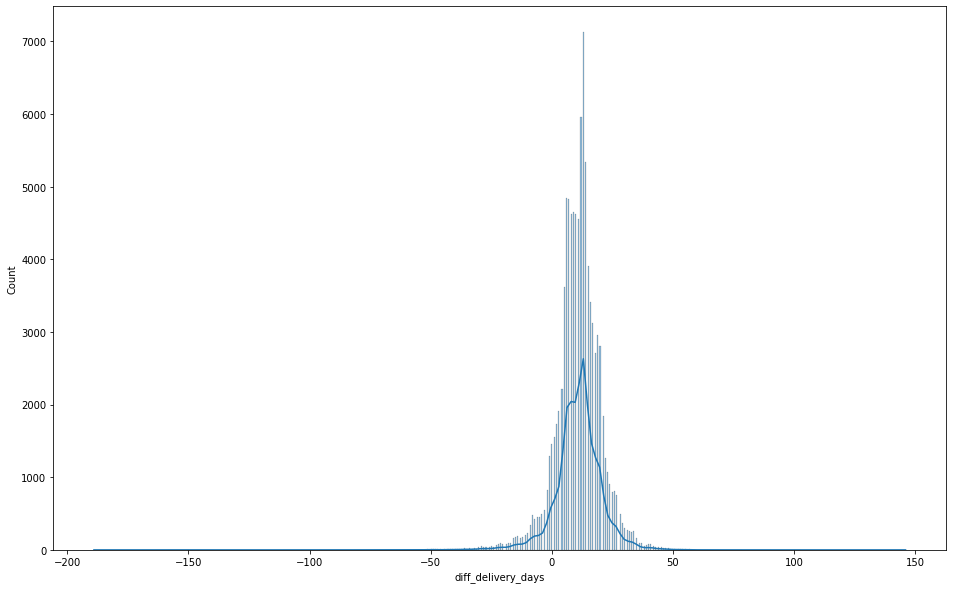

In [12]:
print(df_orders['diff_delivery_days'].describe())
plt.figure(figsize=(16,10))
sns.histplot(x='diff_delivery_days', data=df_orders, kde=True)
plt.plot()

Comme nous pouvons le constater, la différence moyenne entre la livraison estimée et la livraison réelle est de 10 jours, ce qui est un peu élevé. Un autre fait marquant est qu'une commande a été livrée 6 mois plus tard. On pourra éventuellement mettre en lien le retard de la livraison avec la note laissée par le client.

### olist_order_items_dataset

In [13]:
df_item = dic_df['olist_order_items_dataset']

df_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [14]:
df_item.shape

(112650, 7)

Ici également, on a un dataset très intéressant sur les produits commandés. 
- Les colonnes order_id d'une part, et product_id et seller_id d'autre part, vont permettre de mettre en relation les clients et les produits qu'ils achètent dans le dataset final, et de mieux caractériser la consommation des clients (catégories de produits achetés, infos sur ces produits, vendeurs auxquels ils ont achetés des produits, etc)
- Les colonnes price et freight_value vont également permettre de renseigner le niveau de dépenses des clients sur la plateforme (question des frais de port, à inclure ou pas ?)

### olist_customers_dataset

In [15]:
df_customers = dic_df['olist_customers_dataset']

df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [16]:
df_customers.shape

(99441, 5)

In [17]:
df_customers['customer_unique_id'].nunique()

96096

Ce jeu de données est notre jeu de données central, puisqu'on veut segmenter les clients. Il va donc constituer l'ossature de notre jeu de données final, et on va l'enrichir au fur et à mesure dans la deuxième partie de ce notebook. 

En outre, on note que la colonne customer_id semble correspondre à un identifiant unique pour chaque transaction (un même client peut donc en avoir plusieurs). Elle va donc être utile dans un premier temps pour faire la jointure avec les autres datasets, mais c'est la colonne 'customer_unique_id' qui sera vraiment essentielle pour opérer un groupby et regrouper les informations d'un même client.

### olist_geolocation_dataset

In [18]:
df_geolocation = dic_df['olist_geolocation_dataset']

df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [19]:
df_geolocation.shape

(1000163, 5)

Ce dataset comporte des données de géolocalisation d'ordre général. Ce jeu de données n'est pas un élément majeur, mais il pourra être intéressant pour intégrer la dimension géographique à notre problème et d'enrichir certaines informations.

In [20]:
df_geolocation['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [21]:
import matplotlib
import urllib

def plot_brasil_map(data):
    brazil = matplotlib.image.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
    ax = data.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat", figsize=(10,10), alpha=0.3,s=0.3,c='blue')
    plt.axis('off')
    plt.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
    plt.show()

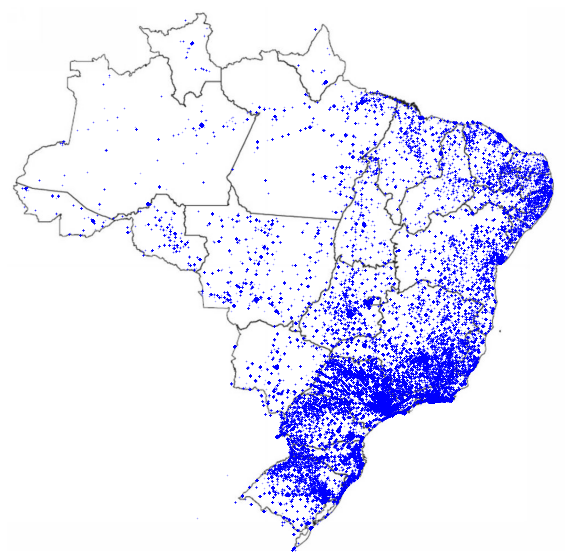

In [22]:
plot_brasil_map(df_geolocation)

### olist_order_payments_dataset

In [23]:
df_order_pay = dic_df['olist_order_payments_dataset']

df_order_pay.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [24]:
df_order_pay.shape

(103886, 5)

Ce jeu de données concerne le paiement des commandes (type de paiement, valeur des paiements). Il comporte des informations sur la nature des paiements et leur montant qui pourraient être reliées à nos clients.

### olist_order_reviews_dataset

In [25]:
df_reviews = dic_df['olist_order_reviews_dataset']

df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [26]:
df_reviews.shape

(99224, 7)

Ce jeu de données comporte les données relatives aux avis laissés par les consommateurs après réception de leur commande. 
Ces données peuvent être jointes aux commandes effectuées par les clients avec la colonne order_id.
Des informations relatives à l'avis laissé (review_score, éventuellement review_comment message, review_creation_date) pourront en outre être exploitées pour detérminer le niveau de satisfaction générale des clients sur l'ensemble de leurs commandes.

### olist_products_dataset

In [27]:
df_products = dic_df['olist_products_dataset']

df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [28]:
df_products.shape

(32951, 9)

Enfin, on a un jeu de données qui concerne les différents produits, et qui donne des informations sur les caractéristiques de ces produits (catégorie, poids, taille) et de leur annonce (nombre de photos). Il doit permettre d'enrichir notre jeu de données final d'informations sur les produits achetés par les différents clients.

# 2. Constitution d'un nouveau jeu de données

In [29]:
clean_df = df_orders.merge(df_item, on='order_id', how='left')
clean_df = clean_df.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
clean_df = clean_df.merge(df_reviews, on='order_id', how='outer')
clean_df = clean_df.merge(df_products, on='product_id', how='outer')
clean_df = clean_df.merge(df_customers, on='customer_id', how='outer')
clean_df = clean_df.merge(df_sellers, on='seller_id', how='outer')

In [30]:
clean_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_delivery_days,order_item_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7.0,1.0,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7.0,1.0,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7.0,1.0,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,9.0,1.0,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,7.0,1.0,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [31]:
clean_df.shape

(119143, 40)

In [32]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def cross_heatmap(df, cols, normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]], 
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [33]:
resumetable(clean_df)

Dataset Shape: (119143, 40)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,e481f51cbdc54678b7cc49136f2d6af7,16.46
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,9ef432eb6251297304e76186b10a928d,16.46
2,order_status,object,0,8,delivered,delivered,delivered,0.25
3,order_purchase_timestamp,datetime64[ns],0,98875,2017-10-02 10:56:33,2017-10-02 10:56:33,2017-10-02 10:56:33,16.44
4,order_approved_at,datetime64[ns],177,90733,2017-10-02 11:07:15,2017-10-02 11:07:15,2017-10-02 11:07:15,16.28
5,order_delivered_carrier_date,datetime64[ns],2086,81018,2017-10-04 19:55:00,2017-10-04 19:55:00,2017-10-04 19:55:00,16.03
6,order_delivered_customer_date,datetime64[ns],3421,95664,2017-10-10 21:25:13,2017-10-10 21:25:13,2017-10-10 21:25:13,16.40
7,order_estimated_delivery_date,datetime64[ns],0,459,2017-10-18 00:00:00,2017-10-18 00:00:00,2017-10-18 00:00:00,8.47
8,diff_delivery_days,float64,3421,198,7.0,7.0,7.0,5.16
9,order_item_id,float64,833,21,1.0,1.0,1.0,0.72


On va finir par faire un peu de feature engineering, en transformant les colonnes review_comment_title et review_comment_message par deux colonnes has_title et comment_words_number

In [34]:
def is_a_title(review_comment_title):

    if (review_comment_title != review_comment_title) or (review_comment_title == ''):
        return False

    else:
        return True

In [35]:
clean_df['has_title'] = clean_df['review_comment_title'].map(is_a_title)

In [36]:
def review_words_count(review_comment_message):
        if (review_comment_message != review_comment_message) or (review_comment_message == ''):
            return 0
        else:
            return(len(review_comment_message.split(' ')))

In [37]:
clean_df['review_words_number'] = clean_df['review_comment_message'].map(review_words_count)

In [38]:
clean_df = clean_df.drop(['review_comment_message', 'review_comment_title'], axis=1)

# 3. Cleaning des données

### Traitement des outliers

In [39]:
clean_df.min()

/var/folders/h1/vf48qfd525d454fjhvbdc4180000gn/T/ipykernel_78426/1178887322.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  clean_df.min()


order_id                         00010242fe8c5a6d1ba2dd792cb16214
customer_id                      00012a2ce6f8dcda20d059ce98491703
order_status                                             approved
order_purchase_timestamp                      2016-09-04 21:15:19
order_approved_at                             2016-09-15 12:16:38
order_delivered_carrier_date                  2016-10-08 10:34:01
order_delivered_customer_date                 2016-10-11 13:46:32
order_estimated_delivery_date                 2016-09-30 00:00:00
diff_delivery_days                                         -189.0
order_item_id                                                 1.0
price                                                        0.85
freight_value                                                 0.0
payment_sequential                                            1.0
payment_installments                                          0.0
payment_value                                                 0.0
review_sco

On va supprimer les individus du datraframe pour lesquels les prix sont négatifs.

In [40]:
to_drop = clean_df[clean_df['price'] < 0].index

In [41]:
clean_df = clean_df.drop(to_drop)

### Traitement des valeurs manquantes

<AxesSubplot:>

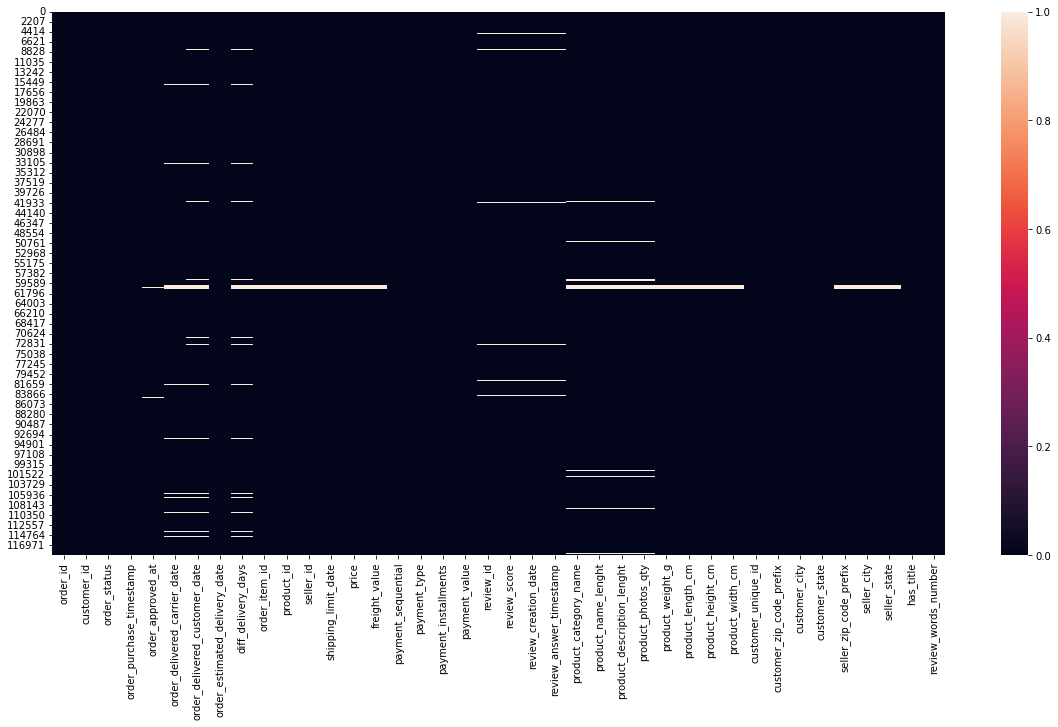

In [42]:
plt.figure(figsize=(20,10))
sns.heatmap(clean_df.isna(), cbar=True)

In [43]:
(clean_df.isna().sum()/clean_df.shape[0]).sort_values(ascending=False)

order_delivered_customer_date    0.028713
diff_delivery_days               0.028713
product_name_lenght              0.021336
product_description_lenght       0.021336
product_category_name            0.021336
product_photos_qty               0.021336
order_delivered_carrier_date     0.017508
review_answer_timestamp          0.008368
review_creation_date             0.008368
review_id                        0.008368
review_score                     0.008368
product_height_cm                0.007159
product_length_cm                0.007159
product_weight_g                 0.007159
product_width_cm                 0.007159
seller_id                        0.006992
product_id                       0.006992
price                            0.006992
freight_value                    0.006992
order_item_id                    0.006992
seller_city                      0.006992
seller_zip_code_prefix           0.006992
seller_state                     0.006992
shipping_limit_date              0

Parmi les valeurs manquantes restantes, certaines n'ont pas d'intérêt à être imputées (ID et dates, variables catégorielles).  Nous allons donc tout simplement les supprimer de notre jeu de données.

In [44]:
col_not_to_impute = ['order_delivered_customer_date',
                     'order_delivered_carrier_date',
                     'review_id',
                     'review_answer_timestamp',
                     'review_creation_date',
                     'order_approved_at',
                     'product_category_name',
                     'payment_type'                
                    ]

In [45]:
for e in col_not_to_impute:
    to_drop = clean_df[clean_df[e].isna()].index
    clean_df = clean_df.drop(to_drop, axis=0)

Enfin, pour les dernières valeurs manquantes, on va avoir recours à un Iterative Imputer.

In [46]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer

to_impute_col = ['product_photos_qty',
                 'product_description_lenght',
                 'product_name_lenght',
                 'review_score',
                 'product_width_cm',
                 'product_weight_g',
                 'product_length_cm',
                 'product_height_cm',
                 'payment_sequential',
                 'payment_installments',
                 'payment_value'
                ]

imputer = IterativeImputer()

imputed_data = imputer.fit_transform(clean_df[to_impute_col])
df_temp = pd.DataFrame(imputed_data)
df_temp.columns = to_impute_col
clean_df[to_impute_col] = df_temp[to_impute_col].values 

In [47]:
clean_df.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
diff_delivery_days               0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm   

# 4. Analyse exploratoire

# Analyse univariée

### Distribution des prix

/Users/leodray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leodray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


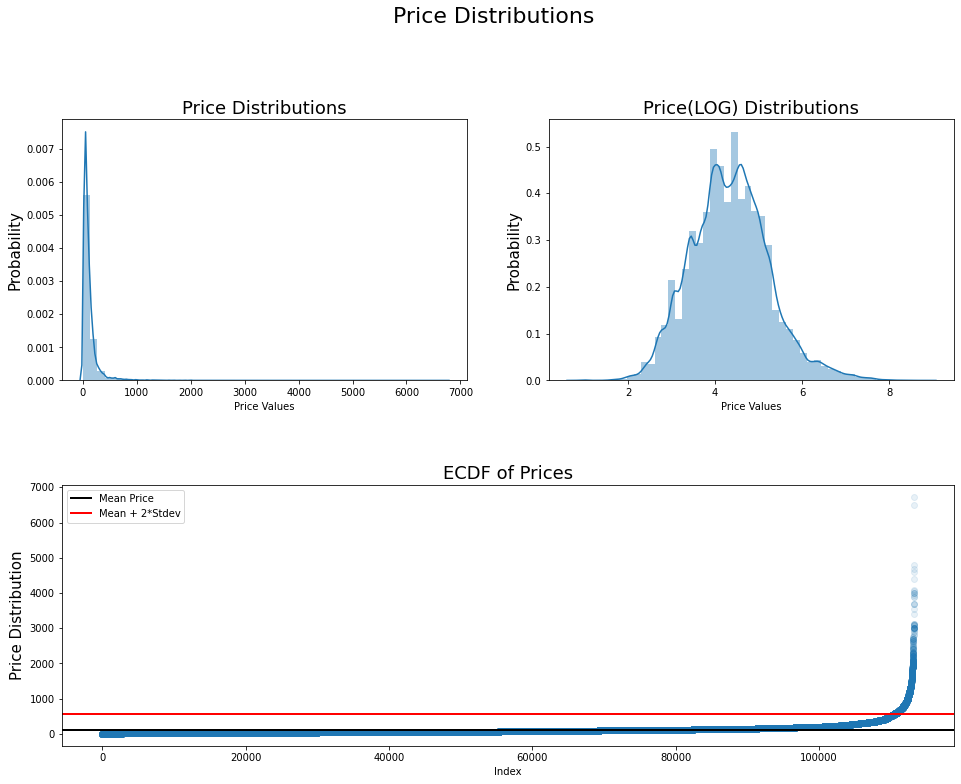

In [48]:
clean_df['price'].fillna(-1, inplace=True)

plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.distplot(clean_df['price'])
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(clean_df['price']+1.5))
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values")
g1.set_ylabel("Probability", fontsize=15)

plt.subplot(212)
g4 = plt.scatter(range(clean_df.shape[0]),
                 np.sort(clean_df['price'].values), 
                 alpha=.1)
g4= plt.title("ECDF of Prices", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Price Distribution", fontsize=15)
g4 = plt.axhline(clean_df[clean_df['price'] != -1]['price'].mean(), color='black', 
           label='Mean Price', linewidth=2)
g4 = plt.axhline(clean_df[clean_df['price'] != -1]['price'].mean() + (2.5*clean_df[clean_df['price'] != -1]['price'].std()),
                 color='red', 
           label='Mean + 2*Stdev', linewidth=2)
g4 = plt.legend()

plt.subplots_adjust(hspace = 0.4, top = 0.85)


In [49]:
clean_df['price_log'] = np.log(clean_df['price'] + 1.5)

### Types de paiements

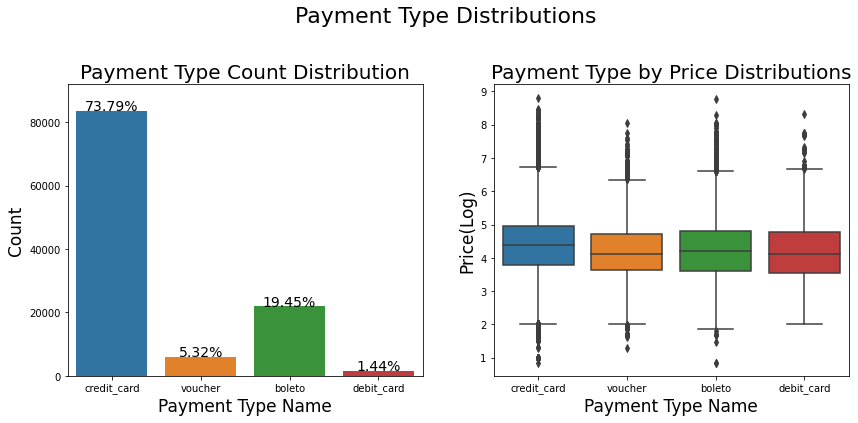

In [50]:
total = len(clean_df)

plt.figure(figsize=(14,6))

plt.suptitle('Payment Type Distributions', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=clean_df[clean_df['payment_type'] != 'not_defined'])
g.set_title("Payment Type Count Distribution", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type', y='price_log', data=clean_df[clean_df['payment_type'] != 'not_defined'])
g.set_title("Payment Type by Price Distributions", fontsize=20)
g.set_xlabel("Payment Type Name", fontsize=17)
g.set_ylabel("Price(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

### Les états de provenance des clients

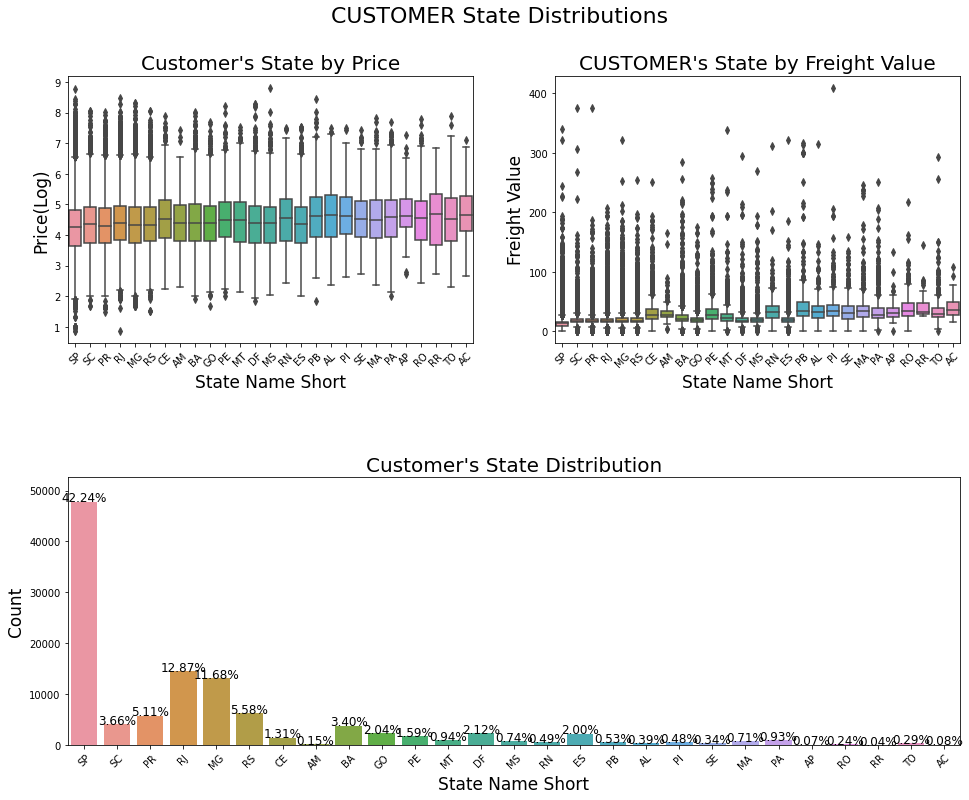

In [51]:
plt.figure(figsize=(16,12))

plt.suptitle('CUSTOMER State Distributions', fontsize=22)

plt.subplot(212)
g = sns.countplot(x='customer_state', data=clean_df, orient='h')
g.set_title("Customer's State Distribution", fontsize=20)
g.set_xlabel("State Name Short", fontsize=17)
g.set_ylabel("Count", fontsize=17)
’’’
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(221)
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=clean_df[clean_df['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State Name Short", fontsize=17)
g2.set_ylabel("Price(Log)", fontsize=17)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.subplot(222)
g3 = sns.boxplot(x='customer_state', y='freight_value', 
                 data=clean_df[clean_df['price'] != -1])
g3.set_title("CUSTOMER's State by Freight Value", fontsize=20)
g3.set_xlabel("State Name Short", fontsize=17)
g3.set_ylabel("Freight Value", fontsize=17)
g3.set_xticklabels(g3.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.5, top = 0.9)

plt.show()

### Analyse des fréquence d'achats et du montant dépensé pour chaque client

On commence par faire un groupby par unique_customer_id pour rassembler les informations pour chaque client. Il s'agit d'une étape cruciale, puisque c'est la version groupée de notre dataframe que nous utiliserons par la suite pour modéliser la segmentation clients.

In [52]:
clean_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'diff_delivery_days', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_id',
       'review_score', 'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'has_title', 'review_words_number', 'price_log'],
      dtype='object')

In [53]:
dic_group = {'order_id': 'count', #Count for frequency ?
             #'order_status': , # ----> TO DROP ?
             'order_approved_at': ['min', 'max'],
             #'order_delivered_carrier_date': ,
             #'order_delivered_customer_date': , 
             #'order_estimated_delivery_date': , ---> For the date, first and late ? (recency + first order)
             'diff_delivery_days': ['mean', 'sum'], 
             #'order_item_id': ,
             #'product_id': ,
             #'seller_id': ,
             #'shipping_limit_date': ,
             'price': 'sum', #Sum pour monetary
             'freight_value': 'sum',
             #'payment_sequential': , #----> TO DROP ?
             'payment_type': pd.Series.mode,
             #'payment_installments': pd.Series.mode, #-----> TO DROP ?
             #'payment_value': , #-----> TO DROP ?
             #'review_id': , #-----> TO DROP ?
             'review_score': ['min', 'max', 'mean'], #--> Min, max, mean ?
             #'review_creation_date': ,
             #'review_answer_timestamp': ,
             'product_category_name': pd.Series.mode,
             'product_name_lenght': 'mean', #----> TO DROP ?
             'product_description_lenght': 'mean',
             'product_photos_qty': 'mean',
             'product_weight_g': 'mean',
             'product_length_cm': 'mean',
             'product_height_cm': 'mean',
             'product_width_cm': 'mean',
             'customer_zip_code_prefix': pd.Series.mode,
             'customer_city': pd.Series.mode,
             'customer_state': pd.Series.mode,
             'seller_zip_code_prefix': pd.Series.mode, #--> Aggréagtion dans une chaîne de caractère ?
             'seller_city': pd.Series.mode, #--> Aggréagtion dans une chaîne de caractère ?
             'seller_state': pd.Series.mode, #--> Aggréagtion dans une chaîne de caractère ?
             'has_title': pd.Series.mode,
             'review_words_number': 'mean',
             'price_log': 'sum'
}

In [54]:
final_df = clean_df.groupby('customer_unique_id').agg(dic_group)

In [55]:
final_df.head()

order_id   order_approved_at  \
                                    count                 min   
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2        1 2018-05-10 11:11:18   
0000b849f77a49e4a4ce2b2a4ca5be3f        1 2018-05-07 18:25:44   
0000f46a3911fa3c0805444483337064        1 2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078        1 2017-10-12 20:49:17   
0004aac84e0df4da2b147fca70cf8255        1 2017-11-14 20:06:52   

                                                     diff_delivery_days        \
                                                 max               mean   sum   
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 11:11:18                4.0   4.0   
0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 18:25:44                4.0   4.0   
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03                1.0   1.0   
0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:49:17               11.0  11.0   
0004aac84e0df4da2b147fca70cf8255 2017-11-14 20:06:52                7.0   7.0   

                                   price freight_value payment_type  \
                                     sum           sum         mode   
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2  129.90         12.00  credit_card   
0000b849f77a49e4a4ce2b2a4ca5be3f   18.90          8.29  credit_card   
0000f46a3911fa3c0805444483337064   69.00         17.22  credit_card   
0000f6ccb0745a6a4b88665a16c9f078   25.99         17.63  credit_card   
0004aac84e0df4da2b147fca70cf8255  180.00         16.89  credit_card   

                                 review_score       ... product_width_cm  \
                                          min  max  ...             mean   
customer_unique_id                                  ...                    
0000366f3b9a7992bf8c76cfdf3221e2          5.0  5.0  ...             32.0   
0000b849f77a49e4a4ce2b2a4ca5be3f          4.0  4.0  ...             18.0   
0000f46a3911fa3c0805444483337064          3.0  3.0  ...             35.0   
0000f6ccb0745a6a4b88665a16c9f078          4.0  4.0  ...             11.0   
0004aac84e0df4da2b147fca70cf8255          5.0  5.0  ...             11.0   

                                 customer_zip_code_prefix customer_city  \
                                                     mode          mode   
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                     7787       cajamar   
0000b849f77a49e4a4ce2b2a4ca5be3f                     6053        osasco   
0000f46a3911fa3c0805444483337064                    88115      sao jose   
0000f6ccb0745a6a4b88665a16c9f078                    66812         belem   
0004aac84e0df4da2b147fca70cf8255                    18040      sorocaba   

                                 customer_state seller_zip_code_prefix  \
                                           mode                   mode   
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2             SP                13405.0   
0000b849f77a49e4a4ce2b2a4ca5be3f             SP                 2215.0   
0000f46a3911fa3c0805444483337064             SC                13232.0   
0000f6ccb0745a6a4b88665a16c9f078             PA                 3569.0   
0004aac84e0df4da2b147fca70cf8255             SP                12327.0   

                                           seller_city seller_state has_title  \
                                                  mode         mode      mode   
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2            piracicaba           SP      True   
0000b849f77a49e4a4ce2b2a4ca5be3f             sao paulo           SP     False   
0000f46a3911fa3c0805444483337064  campo limpo paulista           SP     False   
0000f

In [56]:
final_df[final_df['order_id']['count'] > 1]

order_id   order_approved_at  \
                                    count                 min   
customer_unique_id                                              
00053a61a98854899e70ed204dd4bafe        2 2018-02-28 11:32:42   
000bfa1d2f1a41876493be685390d6d3        2 2017-09-29 15:04:28   
000de6019bb59f34c099a907c151d855        2 2017-08-17 19:55:22   
000e309254ab1fc5ba99dd469d36bdb4        2 2018-06-25 10:14:04   
000fbf0473c10fc1ab6f8d2d286ce20c        4 2018-07-27 02:05:20   
...                                   ...                 ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea        2 2018-05-13 16:15:16   
fff22793223fe80c97a8fd02ac5c6295        3 2018-06-26 11:18:21   
fff5eb4918b2bf4b2da476788d42051c        6 2018-07-05 16:04:19   
fff7219c86179ca6441b8f37823ba3d3        2 2017-12-28 14:07:35   
fffcf5a5ff07b0908bd4e2dbc735a684        2 2017-06-08 21:15:16   

                                                     diff_delivery_days        \
                                                 max               mean   sum   
customer_unique_id                                                              
00053a61a98854899e70ed204dd4bafe 2018-02-28 11:32:42                9.0  18.0   
000bfa1d2f1a41876493be685390d6d3 2017-09-29 15:04:28               12.0  24.0   
000de6019bb59f34c099a907c151d855 2017-08-17 19:55:22               15.0  30.0   
000e309254ab1fc5ba99dd469d36bdb4 2018-06-25 10:14:04               14.0  28.0   
000fbf0473c10fc1ab6f8d2d286ce20c 2018-07-27 02:05:20               13.0  52.0   
...                                              ...                ...   ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea 2018-05-13 16:15:16               -7.0 -14.0   
fff22793223fe80c97a8fd02ac5c6295 2018-06-26 11:18:21               17.0  51.0   
fff5eb4918b2bf4b2da476788d42051c 2018-07-05 16:04:19               15.0  90.0   
fff7219c86179ca6441b8f37823ba3d3 2017-12-28 14:07:35               11.0  22.0   
fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:15:16               26.0  52.0   

                                   price freight_value  \
                                     sum           sum   
customer_unique_id                                       
00053a61a98854899e70ed204dd4bafe   382.0         37.18   
000bfa1d2f1a41876493be685390d6d3    70.0         23.70   
000de6019bb59f34c099a907c151d855   229.8         27.64   
000e309254ab1fc5ba99dd469d36bdb4   119.8         37.04   
000fbf0473c10fc1ab6f8d2d286ce20c   285.8         76.56   
...                                  ...           ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea   330.0         78.40   
fff22793223fe80c97a8fd02ac5c6295    66.0         23.19   
fff5eb4918b2bf4b2da476788d42051c  1050.0       1794.96   
fff7219c86179ca6441b8f37823ba3d3   245.8         20.00   
fffcf5a5ff07b0908bd4e2dbc735a684  1570.0        497.42   

                                            payment_type review_score       \
                                                    mode          min  max   
customer_unique_id                                                           
00053a61a98854899e70ed204dd4bafe             credit_card          1.0  1.0   
000bfa1d2f1a41876493be685390d6d3             credit_card          4.0  5.0   
000de6019bb59f34c099a907c151d855             credit_card          2.0  2.0   
000e309254ab1fc5ba99dd469d36bdb4  [credit_card, voucher]          3.0  3.0   
000fbf0473c10fc1ab6f8d2d286ce20c                  boleto          5.0  5.0   
...                                                  ...          ...  ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea  [credit_card, voucher]          2.0  2.0   
fff22793223fe80c97a8fd02ac5c6295             credit_card          5.0  5.0   
fff5eb4918b2bf4b2da476788d42051c                  boleto          5.0  5.0   
fff7219c86179ca6441b8f37823ba3d3              debit_card          4.0  4.0   
fffcf5a5ff07b0908bd4e2dbc735a684             credit_card          5.0  5.0   

                                  ... product_width_cm  \
                       

# Analyse multivariée

### Les corrélations entre catégorie de produit et prix 

[]

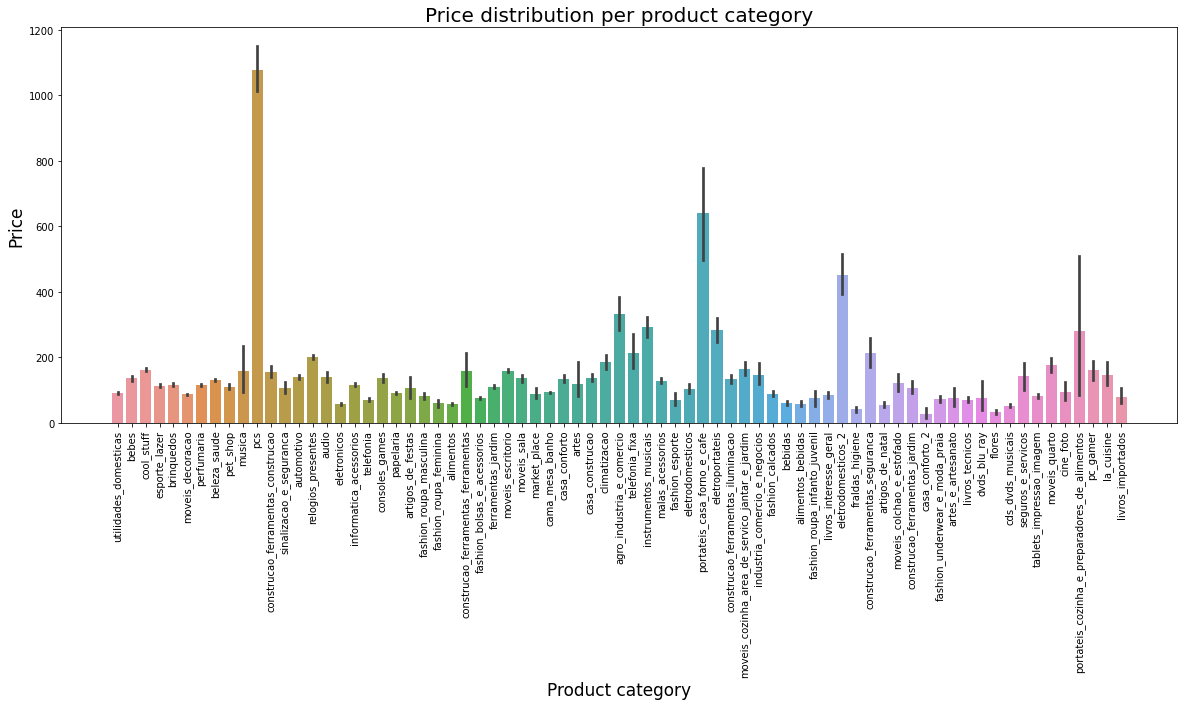

In [58]:
plt.figure(figsize=(20,16))

plt.subplot(212)
g = sns.barplot(x='product_category_name', y='price', data=clean_df)
g.set_title("Price distribution per product category", fontsize=20)
g.set_xlabel("Product category", fontsize=17)
g.set_ylabel("Price", fontsize=17)
plt.xticks(rotation=90)

plt.plot()


In [59]:
clean_df['price'][clean_df['product_category_name'] == 'pcs'].describe()

count     213.000000
mean     1078.721221
std       527.138863
min        34.500000
25%       650.000000
50%      1100.000000
75%      1340.000000
max      4590.000000
Name: price, dtype: float64

### Les corrélations entre délai de livraison et review_score

[]

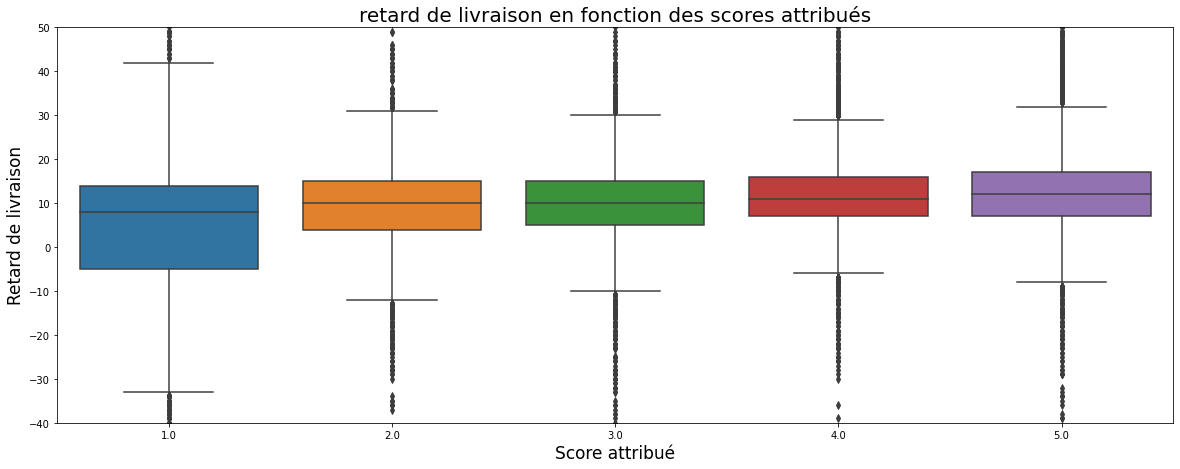

In [60]:
plt.figure(figsize=(20,16))

plt.subplot(212)
g = sns.boxplot(x='review_score', y='diff_delivery_days', data=clean_df)
g.set_title("retard de livraison en fonction des scores attribués", fontsize=20)
g.set_xlabel("Score attribué", fontsize=17)
g.set_ylabel('Retard de livraison', fontsize=17)
g.set_ylim((-40, 50))
plt.plot()


### Heatmap des corrélations linéaires 

<AxesSubplot:>

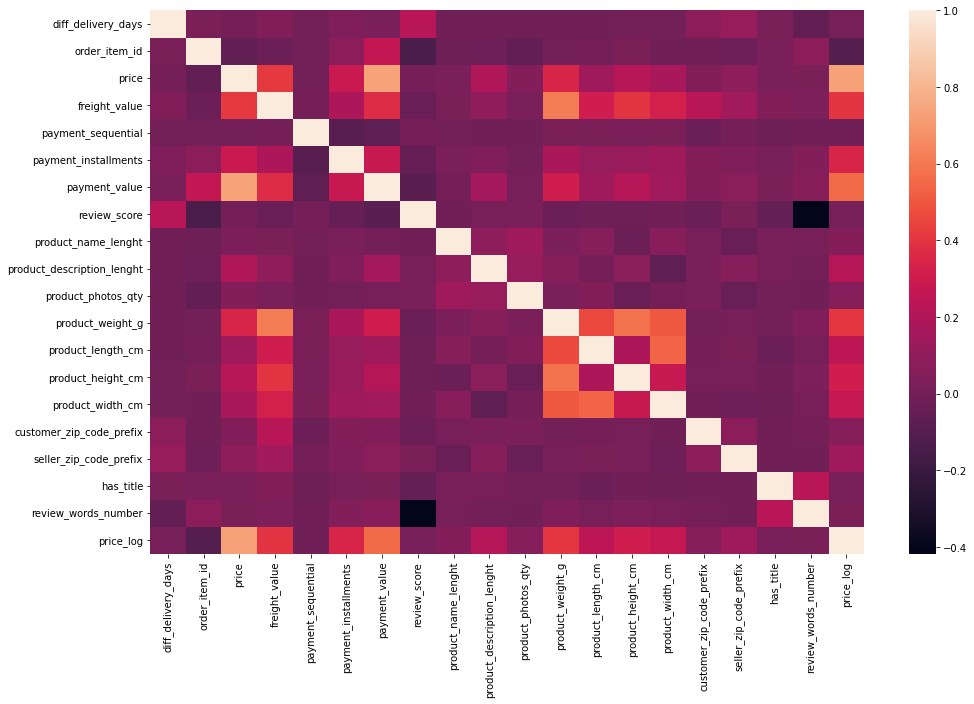

In [61]:
plt.figure(figsize=(16, 10))
sns.heatmap(clean_df.corr())

### Analyse des fréquence d'achats et du montant dépensé pour chaque client

On commence par faire un groupby par unique_customer_id pour rassembler les informations pour chaque client. Il s'agit d'une étape cruciale, puisque c'est la version groupée de notre dataframe que nous utiliserons par la suite pour modéliser la segmentation clients.

In [62]:
#Feature engineering stirngs ?
#Feature engineering date ?

In [63]:
clean_df['order_approved_at'][0]

Timestamp('2017-10-02 11:07:15')

In [64]:
dic_group = {'order_id': 'count', #Count for frequency 
             #'order_status': , # ----> TO DROP 
             
             #For the date, last order to analyse recency of activity and first order for customer seniority? 
             #No need to take into account all dates since we already have indicator with diff_delivery_days
             #Choose one of reference --> Order approved because most standard time between client order and approval
             
             'order_approved_at': [np.min, np.max],
             #'order_delivered_carrier_date': ,
             #'order_delivered_customer_date': , 
             #'order_estimated_delivery_date': , ---> For the date, first and late ? (recency + first order)
             'diff_delivery_days': 'sum', 
             #'order_item_id': , # -----> TO DROP
             #'product_id': , # -----> TO DROP ? --> Aggréagtion dans une chaîne de caractère ?
             #'seller_id': , # ------> TO DROP ? --> Aggréagtion dans une chaîne de caractère ?
             #'shipping_limit_date': , -----> TO DROP
             'price': 'sum', #Sum pour monetary
             'freight_value': 'sum',
             #'payment_sequential': , #----> TO DROP 
             'payment_type': pd.Series.mode,
             #'payment_installments': pd.Series.mode, #-----> TO DROP 
             #'payment_value': , #-----> TO DROP ?
             #'review_id': , #-----> TO DROP 
             'review_score': 'sum', #--> Min, max, mean ?
             #'review_creation_date': , #----> TO DROP
             #'review_answer_timestamp': , #-----> TO DROP
             'product_category_name': pd.Series.mode,
             'product_name_lenght': 'mean', #----> TO DROP ?
             'product_description_lenght': 'mean',
             'product_photos_qty': 'mean',
             'product_weight_g': 'mean',
             'product_length_cm': 'mean',
             'product_height_cm': 'mean',
             'product_width_cm': 'mean',
             'customer_zip_code_prefix': pd.Series.mode,
             'customer_city': pd.Series.mode,
             'customer_state': pd.Series.mode,
             'seller_zip_code_prefix': pd.Series.mode, #--> Aggréagtion dans une chaîne de caractère ?
             'seller_city': pd.Series.mode, #--> Aggréagtion dans une chaîne de caractère ?
             'seller_state': pd.Series.mode, #--> Aggréagtion dans une chaîne de caractère ?
             'has_title': pd.Series.mode,
             'review_words_number': 'sum',
             'price_log': 'sum'
}

In [65]:
final_df = clean_df.groupby('customer_unique_id').agg(dic_group)

Jetons un oeil aux clients qui ont effectué plusieurs achats, et à ceux qui ont acheté à des dates différentes.

In [66]:
final_df[final_df['order_id']['count'] > 1]

order_id   order_approved_at  \
                                    count                amin   
customer_unique_id                                              
00053a61a98854899e70ed204dd4bafe        2 2018-02-28 11:32:42   
000bfa1d2f1a41876493be685390d6d3        2 2017-09-29 15:04:28   
000de6019bb59f34c099a907c151d855        2 2017-08-17 19:55:22   
000e309254ab1fc5ba99dd469d36bdb4        2 2018-06-25 10:14:04   
000fbf0473c10fc1ab6f8d2d286ce20c        4 2018-07-27 02:05:20   
...                                   ...                 ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea        2 2018-05-13 16:15:16   
fff22793223fe80c97a8fd02ac5c6295        3 2018-06-26 11:18:21   
fff5eb4918b2bf4b2da476788d42051c        6 2018-07-05 16:04:19   
fff7219c86179ca6441b8f37823ba3d3        2 2017-12-28 14:07:35   
fffcf5a5ff07b0908bd4e2dbc735a684        2 2017-06-08 21:15:16   

                                                     diff_delivery_days  \
                                                amax                sum   
customer_unique_id                                                        
00053a61a98854899e70ed204dd4bafe 2018-02-28 11:32:42               18.0   
000bfa1d2f1a41876493be685390d6d3 2017-09-29 15:04:28               24.0   
000de6019bb59f34c099a907c151d855 2017-08-17 19:55:22               30.0   
000e309254ab1fc5ba99dd469d36bdb4 2018-06-25 10:14:04               28.0   
000fbf0473c10fc1ab6f8d2d286ce20c 2018-07-27 02:05:20               52.0   
...                                              ...                ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea 2018-05-13 16:15:16              -14.0   
fff22793223fe80c97a8fd02ac5c6295 2018-06-26 11:18:21               51.0   
fff5eb4918b2bf4b2da476788d42051c 2018-07-05 16:04:19               90.0   
fff7219c86179ca6441b8f37823ba3d3 2017-12-28 14:07:35               22.0   
fffcf5a5ff07b0908bd4e2dbc735a684 2017-06-08 21:15:16               52.0   

                                   price freight_value  \
                                     sum           sum   
customer_unique_id                                       
00053a61a98854899e70ed204dd4bafe   382.0         37.18   
000bfa1d2f1a41876493be685390d6d3    70.0         23.70   
000de6019bb59f34c099a907c151d855   229.8         27.64   
000e309254ab1fc5ba99dd469d36bdb4   119.8         37.04   
000fbf0473c10fc1ab6f8d2d286ce20c   285.8         76.56   
...                                  ...           ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea   330.0         78.40   
fff22793223fe80c97a8fd02ac5c6295    66.0         23.19   
fff5eb4918b2bf4b2da476788d42051c  1050.0       1794.96   
fff7219c86179ca6441b8f37823ba3d3   245.8         20.00   
fffcf5a5ff07b0908bd4e2dbc735a684  1570.0        497.42   

                                            payment_type review_score  \
                                                    mode          sum   
customer_unique_id                                                      
00053a61a98854899e70ed204dd4bafe             credit_card          2.0   
000bfa1d2f1a41876493be685390d6d3             credit_card          9.0   
000de6019bb59f34c099a907c151d855             credit_card          4.0   
000e309254ab1fc5ba99dd469d36bdb4  [credit_card, voucher]          6.0   
000fbf0473c10fc1ab6f8d2d286ce20c                  boleto         20.0   
...                                                  ...          ...   
ffeddf8aa7cdecf403e77b2e9a99e2ea  [credit_card, voucher]          4.0   
fff22793223fe80c97a8fd02ac5c6295             credit_card         15.0   
fff5eb4918b2bf4b2da476788d42051c                  boleto         30.0   
fff7219c86179ca6441b8f37823ba3d3              debit_card          8.0   
fffcf5a5ff07b0908bd4e2dbc735a684             credit_card         10.0   

                                                product_category_name  \
                                                                 mode   
customer_unique_id                                                      
00053a61a9885489

In [67]:
final_df[final_df['order_approved_at']['amin'] != final_df['order_approved_at']['amax']]

order_id   order_approved_at  \
                                    count                amin   
customer_unique_id                                              
004288347e5e88a27ded2bb23747066c        2 2017-07-27 14:25:14   
00a39521eb40f7012db50455bf083460        2 2018-05-23 20:35:15   
00cc12a6d8b578b8ebd21ea4e2ae8b27        4 2017-03-21 19:25:22   
011575986092c30523ecb71ff10cb473        2 2018-02-17 16:06:43   
011b4adcd54683b480c4d841250a987f        3 2017-08-22 13:08:00   
...                                   ...                 ...   
ff03923ad1eb9e32304deb7f9b2a45c9        2 2018-04-24 18:37:41   
ff44401d0d8f5b9c54a47374eb48c1b8        4 2017-05-19 21:35:16   
ff8892f7c26aa0446da53d01b18df463        3 2017-05-24 16:22:42   
ff922bdd6bafcdf99cb90d7f39cea5b3        3 2017-02-22 13:05:25   
ffe254cc039740e17dd15a5305035928        2 2017-04-02 16:42:23   

                                                     diff_delivery_days  \
                                                amax                sum   
customer_unique_id                                                        
004288347e5e88a27ded2bb23747066c 2018-01-14 07:49:28               33.0   
00a39521eb40f7012db50455bf083460 2018-06-03 10:50:00               36.0   
00cc12a6d8b578b8ebd21ea4e2ae8b27 2017-03-21 19:25:23               46.0   
011575986092c30523ecb71ff10cb473 2018-04-18 22:11:01               18.0   
011b4adcd54683b480c4d841250a987f 2018-02-15 12:40:28               43.0   
...                                              ...                ...   
ff03923ad1eb9e32304deb7f9b2a45c9 2018-05-28 11:03:54               15.0   
ff44401d0d8f5b9c54a47374eb48c1b8 2017-05-19 21:42:44               64.0   
ff8892f7c26aa0446da53d01b18df463 2017-11-26 23:34:29              -36.0   
ff922bdd6bafcdf99cb90d7f39cea5b3 2017-09-14 14:39:31               22.0   
ffe254cc039740e17dd15a5305035928 2017-04-02 16:42:25               28.0   

                                   price freight_value  \
                                     sum           sum   
customer_unique_id                                       
004288347e5e88a27ded2bb23747066c  317.89         36.48   
00a39521eb40f7012db50455bf083460   81.45         41.80   
00cc12a6d8b578b8ebd21ea4e2ae8b27  199.60         52.80   
011575986092c30523ecb71ff10cb473  182.90         32.00   
011b4adcd54683b480c4d841250a987f  183.43         52.87   
...                                  ...           ...   
ff03923ad1eb9e32304deb7f9b2a45c9  220.64         26.42   
ff44401d0d8f5b9c54a47374eb48c1b8   79.60         56.40   
ff8892f7c26aa0446da53d01b18df463  327.90         68.98   
ff922bdd6bafcdf99cb90d7f39cea5b3   94.79         44.81   
ffe254cc039740e17dd15a5305035928   51.08         29.04   

                                            payment_type review_score  \
                                                    mode          sum   
customer_unique_id                                                      
004288347e5e88a27ded2bb23747066c             credit_card         10.0   
00a39521eb40f7012db50455bf083460             credit_card          8.0   
00cc12a6d8b578b8ebd21ea4e2ae8b27                  boleto         16.0   
011575986092c30523ecb71ff10cb473             credit_card          7.0   
011b4adcd54683b480c4d841250a987f             credit_card         13.0   
...                                                  ...          ...   
ff03923ad1eb9e32304deb7f9b2a45c9  [credit_card, voucher]          6.0   
ff44401d0d8f5b9c54a47374eb48c1b8  [credit_card, voucher]         12.0   
ff8892f7c26aa0446da53d01b18df463             credit_card          8.0   
ff922bdd6bafcdf99cb90d7f39cea5b3             credit_card         13.0   
ffe254cc039740e17dd15a5305035928             credit_card          6.0   

                                                              product_category_name  \
                                                                               mode   
customer_unique_id                                           

Enfin, jetons un oeil aux distributions du nombre de commandes et du montant dépensé par client.

/Users/leodray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leodray/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1000.0)

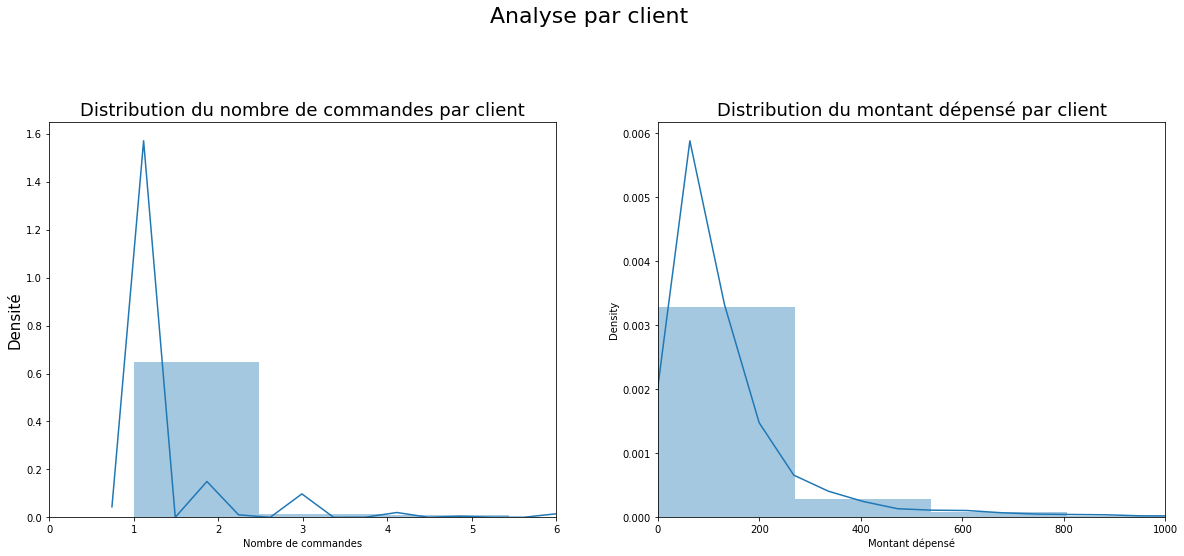

In [68]:
plt.figure(figsize=(20,16))
plt.suptitle('Analyse par client', fontsize=22)
plt.subplot(221)
g = sns.distplot(final_df['order_id']['count'])
g.set_title("Distribution du nombre de commandes par client", fontsize=18)
g.set_xlabel("Nombre de commandes")
g.set_ylabel("Densité", fontsize=15)
g.set_xlim((0, 6))

plt.subplot(222)
g1 = sns.distplot(final_df['price']['sum'])
g1.set_title("Distribution du montant dépensé par client", fontsize=18)
g1.set_xlabel("Montant dépensé")
g1.set_xlim(0, 1000)

Il ne nous reste plus qu'à faire quelques modifications sur le dataframe en vue de l'export des données.

In [69]:
final_df['first_order'] = final_df['order_approved_at']['amin']
final_df['last_order'] = final_df['order_approved_at']['amax']

In [70]:
final_df = final_df.drop('order_approved_at', axis=1)

In [71]:
col_names = [e[0] for e in final_df.columns]
col_names

['order_id',
 'diff_delivery_days',
 'price',
 'freight_value',
 'payment_type',
 'review_score',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'has_title',
 'review_words_number',
 'price_log',
 'first_order',
 'last_order']

In [72]:
final_df.columns = col_names

In [73]:
final_df.head()

,order_id,diff_delivery_days,price,freight_value,payment_type,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,...,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,has_title,review_words_number,price_log,first_order,last_order
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,4.0,129.90,12.00,credit_card,5.0,cama_mesa_banho,60.0,236.0,1.0,...,cajamar,SP,13405.0,piracicaba,SP,True,20,4.878246,2018-05-10 11:11:18,2018-05-10 11:11:18
0000b849f77a49e4a4ce2b2a4ca5be3f,1,4.0,18.90,8.29,credit_card,4.0,beleza_saude,56.0,635.0,1.0,...,osasco,SP,2215.0,sao paulo,SP,False,0,3.015535,2018-05-07 18:25:44,2018-05-07 18:25:44
0000f46a3911fa3c0805444483337064,1,1.0,69.00,17.22,credit_card,3.0,papelaria,49.0,177.0,3.0,...,sao jose,SC,13232.0,campo limpo paulista,SP,False,0,4.255613,2017-03-10 21:05:03,2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078,1,11.0,25.99,17.63,credit_card,4.0,telefonia,43.0,1741.0,5.0,...,belem,PA,3569.0,sao paulo,SP,False,2,3.313822,2017-10-12 20:49:17,2017-10-12 20:49:17
0004aac84e0df4da2b147fca70cf8255,1,7.0,180.00,16.89,credit_card,5.0,telefonia,58.0,794.0,3.0,...,sorocaba,SP,12327.0,jacarei,SP,False,0,5.201256,2017-11-14 20:06:52,2017-11-14 20:06:52


# 5. Export des données

On enregistre les données nettoyées et groupées dans un nouveau csv afin de les réemployer directement dans le deuxième notebook dédié à la modélisation.

In [74]:
if not os.path.exists('final_data.csv'):
    with open('final_data.csv', 'w'): pass
    
final_df.to_csv('final_data.csv')